In [11]:
%matplotlib inline

from importlib import reload
import functools
from functional import compose, partial
import numpy as np
import tensorflow as tf
import plot
import networks as nw
from datetime import datetime
import os
import re
import sys
print(tf.__version__)
import matplotlib.pyplot as plt
import seaborn as sns

1.3.0


In [2]:
# utils and layers
def compose_all(*args):
    return partial(functools.reduce, compose)(*args)

def print_(var, name: str, first_n=5, summarize=5):
    """Util for debugging, by printing values of tf.Variable `var` during training"""
    # (tf.Tensor, str, int, int) -> tf.Tensor
    return tf.Print(var, [var], "{}: ".format(name), first_n=first_n,
                    summarize=summarize)

def get_mnist(n, mnist):
    """Returns 784-D numpy array for random MNIST digit `n`"""
    assert 0 <= n <= 9, "Must specify digit 0 - 9!"
    import random

    SIZE = 500
    imgs, labels = mnist.train.next_batch(SIZE)
    idxs = iter(random.sample(range(SIZE), SIZE)) # non-in-place shuffle

    for i in idxs:
        if labels[i] == n:
            return imgs[i] # first match
        


In [3]:
IMG_DIM = 28

ARCHITECTURE = [IMG_DIM**2, # 784 pixels
                500, 500, # intermediate encoding
                2] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"


def load_mnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets("./mnist_data")

def all_plots(model, mnist):
    if model.architecture[-1] == 2: # only works for 2-D latent
        print("Plotting in latent space...")
        plot_all_in_latent(model, mnist)

        print("Exploring latent...")
        plot.exploreLatent(model, nx=20, ny=20, range_=(-4, 4), outdir=PLOTS_DIR)
        for n in (24, 30, 60, 100):
            plot.exploreLatent(model, nx=n, ny=n, ppf=True, outdir=PLOTS_DIR,
                               name="explore_ppf{}".format(n))

    print("Interpolating...")
    interpolate_digits(model, mnist)

    print("Plotting end-to-end reconstructions...")
    plot_all_end_to_end(model, mnist)

    print("Morphing...")
    morph_numbers(model, mnist, ns=[9,8,7,6,5,4,3,2,1,0])

    print("Plotting 10 MNIST digits...")
    for i in range(10):
        plot.justMNIST(get_mnist(i, mnist), name=str(i), outdir=PLOTS_DIR)

def plot_all_in_latent(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        plot.plotInLatent(model, dataset.images, dataset.labels, name=name,
                          outdir=PLOTS_DIR)

def interpolate_digits(model, mnist):
    imgs, labels = mnist.train.next_batch(100)
    idxs = np.random.randint(0, imgs.shape[0] - 1, 2)
    mus, _ = model.encode(np.vstack(imgs[i] for i in idxs))
    plot.interpolate(model, *mus, name="interpolate_{}->{}".format(
        *(labels[i] for i in idxs)), outdir=PLOTS_DIR)

def plot_all_end_to_end(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        x, _ = dataset.next_batch(10)
        x_reconstructed = model.vae(x)
        plot.plotSubset(model, x, x_reconstructed, n=10, name=name,
                        outdir=PLOTS_DIR)

def morph_numbers(model, mnist, ns=None, n_per_morph=10):
    if not ns:
        import random
        ns = random.sample(range(10), 10) # non-in-place shuffle

    xs = np.squeeze([get_mnist(n, mnist) for n in ns])
    mus, _ = model.encode(xs)
    plot.morph(model, mus, n_per_morph=n_per_morph, outdir=PLOTS_DIR,
               name="morph_{}".format("".join(str(n) for n in ns)))

In [4]:
IMG_DIM = 28

ARCHITECTURE = [IMG_DIM**2, # 784 pixels
                500, 500, # intermediate encoding
                2] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"

mnist = load_mnist()
to_reload = False


Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz


In [5]:
reload(nw)
if to_reload: # restore
    v = nw.VAE(ARCHITECTURE, HYPERPARAMS, meta_graph=to_reload)
    print("Loaded!")

else: # train
    v = nw.VAE(ARCHITECTURE, HYPERPARAMS, log_dir=LOG_DIR)
    v.train(mnist, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False,
            verbose=True, save=True, out_dir=METAGRAPH_DIR, plots_outdir=PLOTS_DIR,
            plot_latent_over_time=False)
    print("Trained!")

all_plots(v, mnist)

clipped
Instructions for updating:
Please use tf.global_variables instead.
------- Training begin: 07:55:05.022048 -------

round 1000 --> avg cost:  221.777244034
round 2000 --> avg cost:  202.472183952
final avg cost (@ step 2000 = epoch 4): 202.47218395233153
------- Training end: 07:55:19.981464 -------

Trained!
Plotting in latent space...
Exploring latent...
Interpolating...
Plotting end-to-end reconstructions...
Morphing...


/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting 10 MNIST digits...


Plotting in latent space...
Exploring latent...
Interpolating...
Plotting end-to-end reconstructions...
Morphing...


/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting 10 MNIST digits...


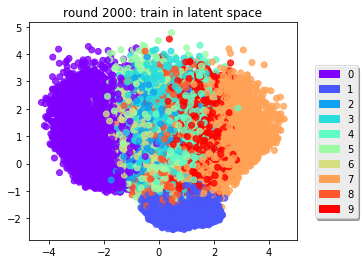

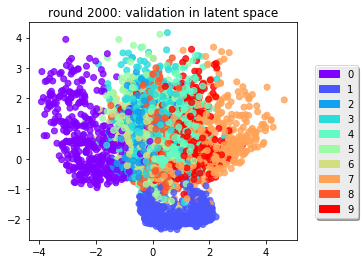

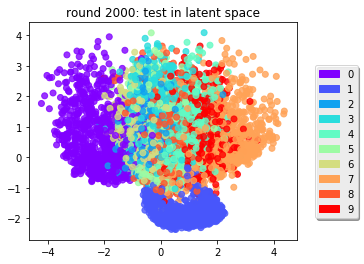

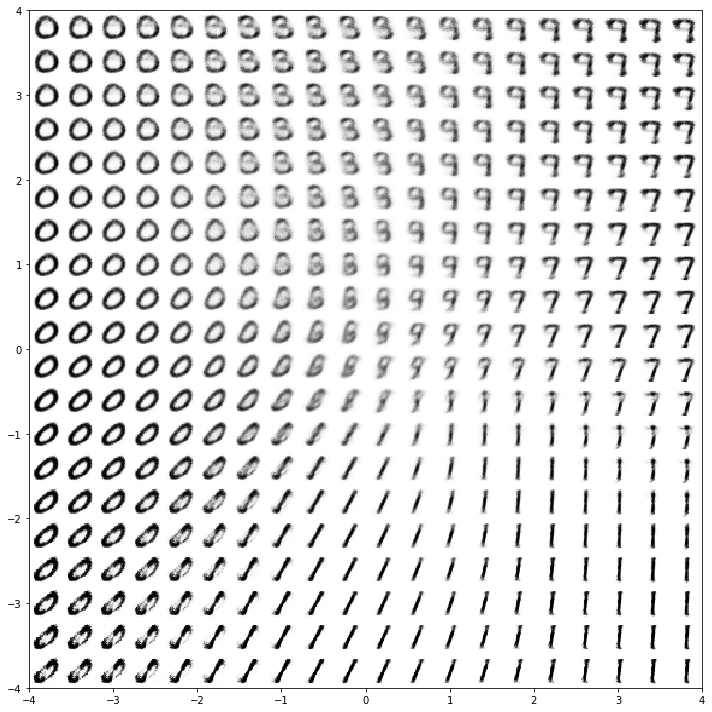

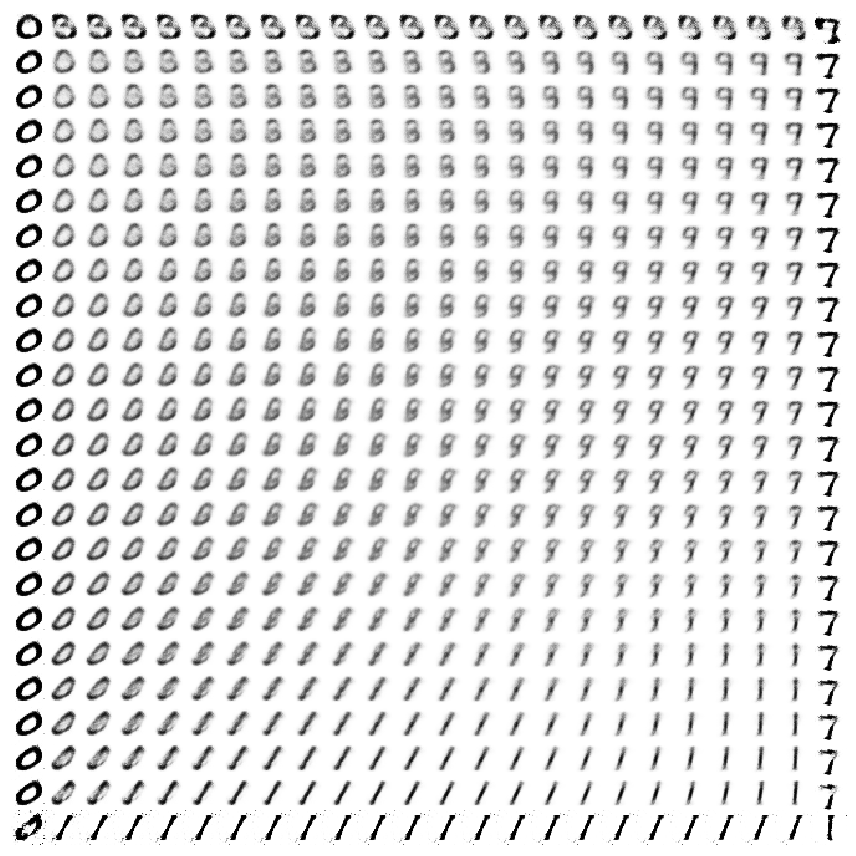

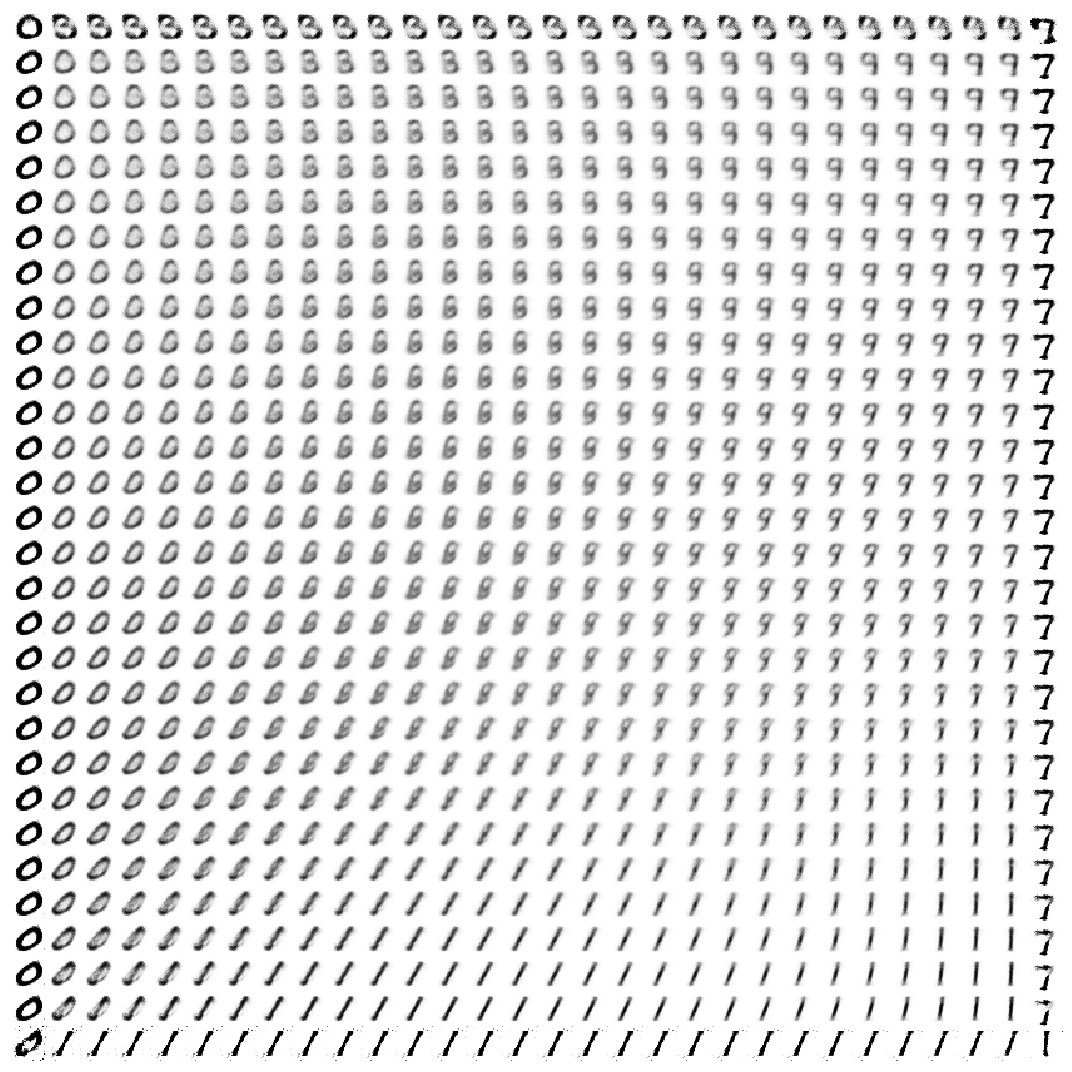

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


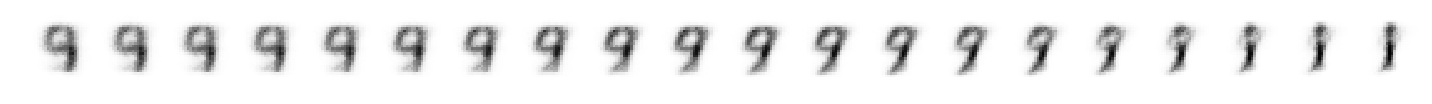

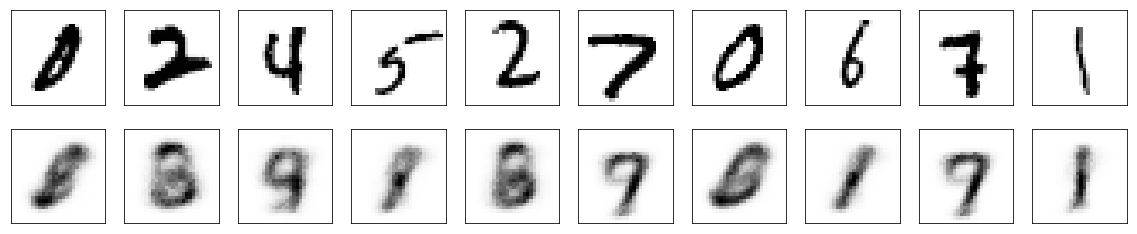

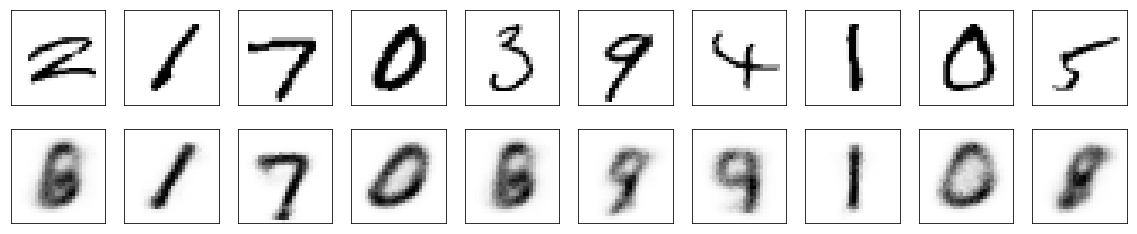

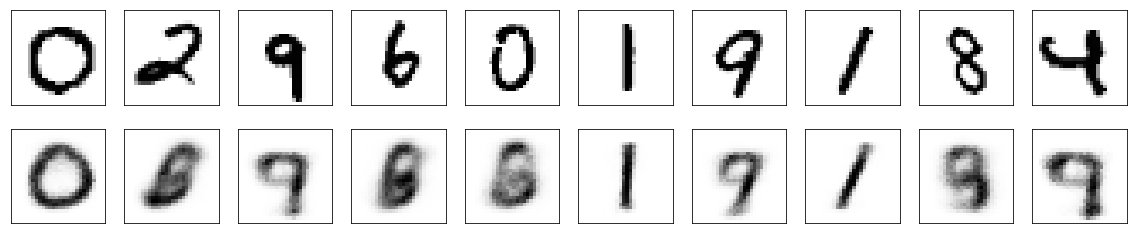

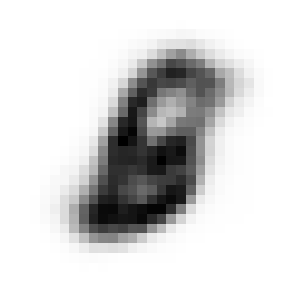

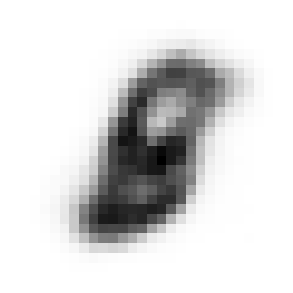

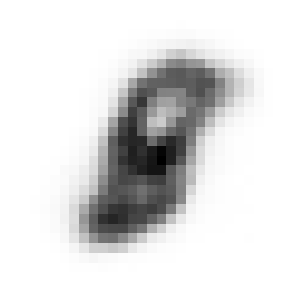

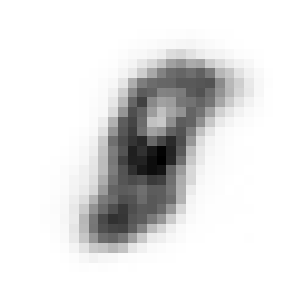

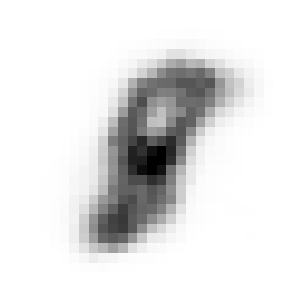

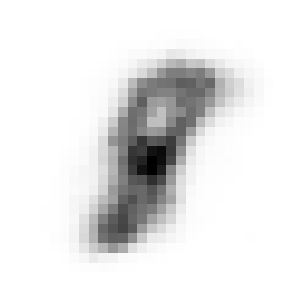

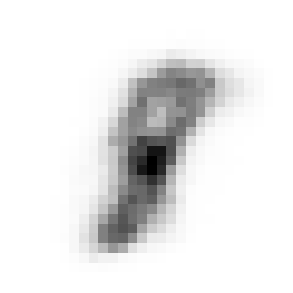

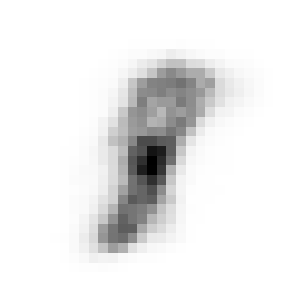

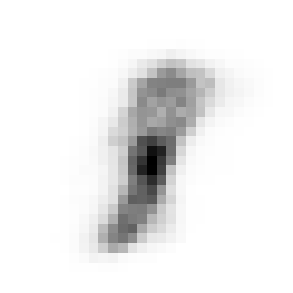

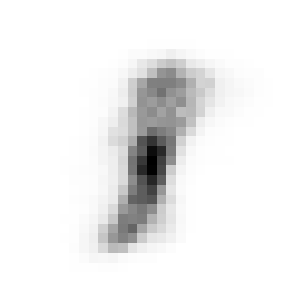

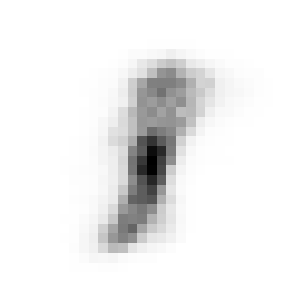

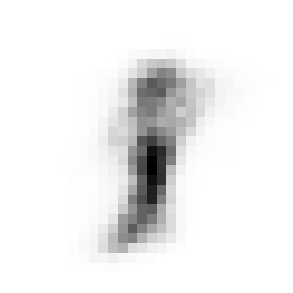

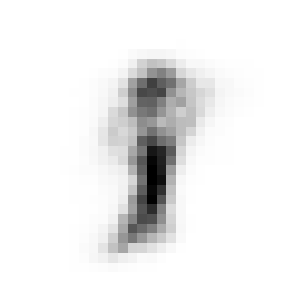

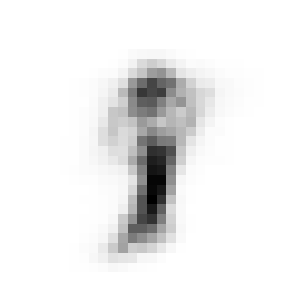

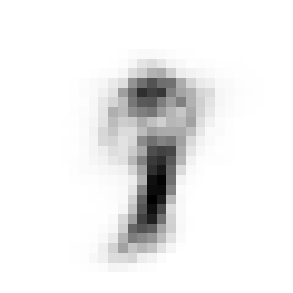

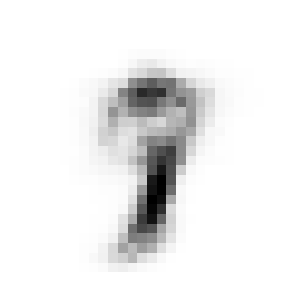

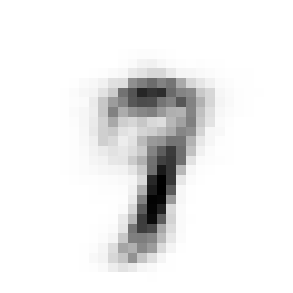

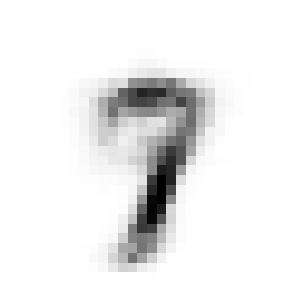

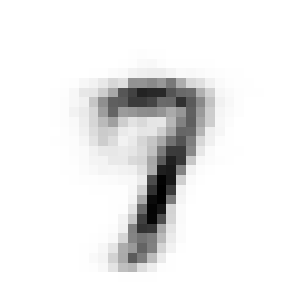

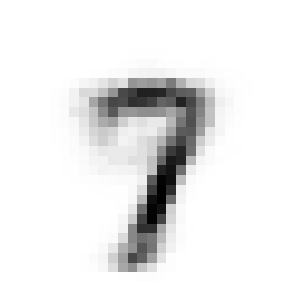

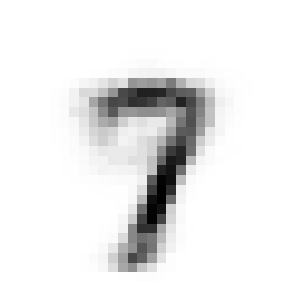

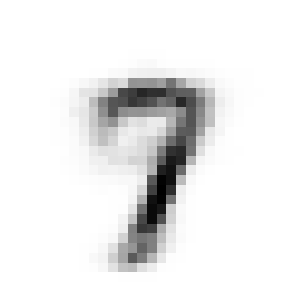

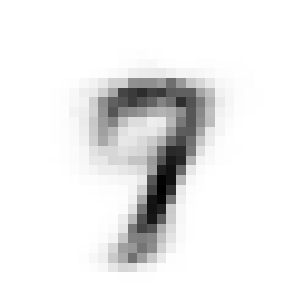

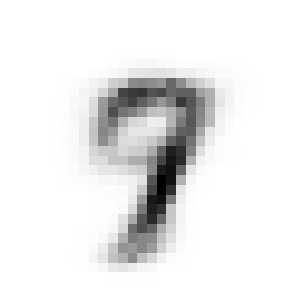

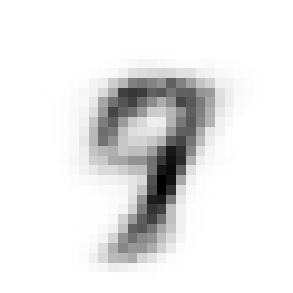

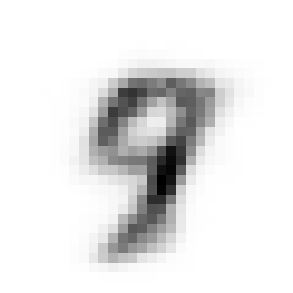

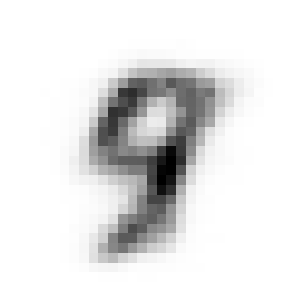

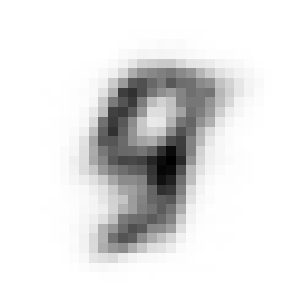

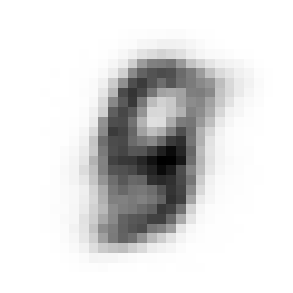

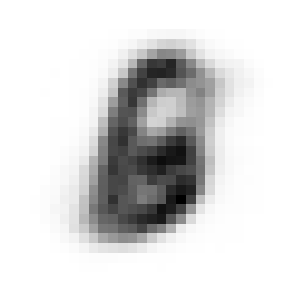

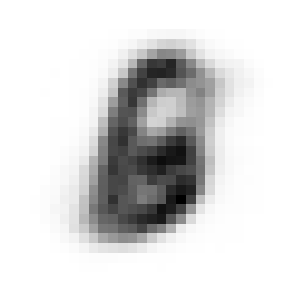

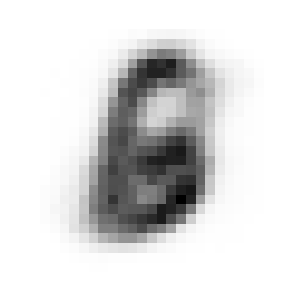

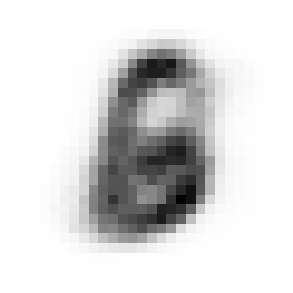

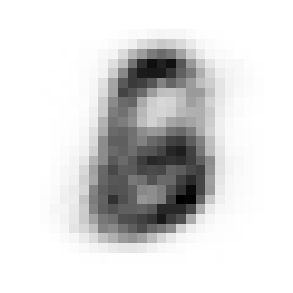

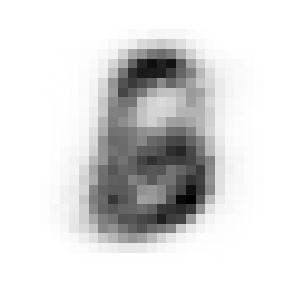

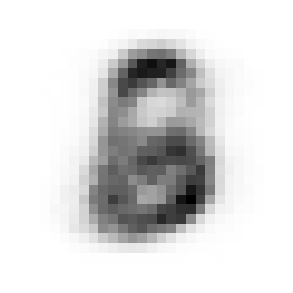

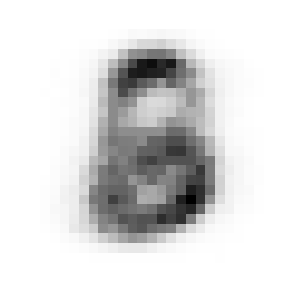

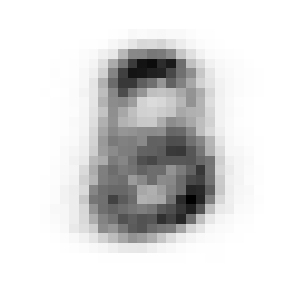

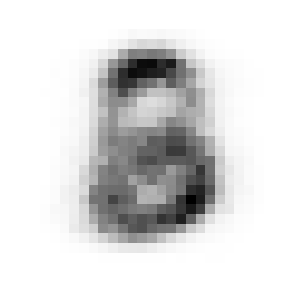

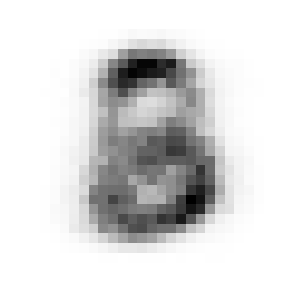

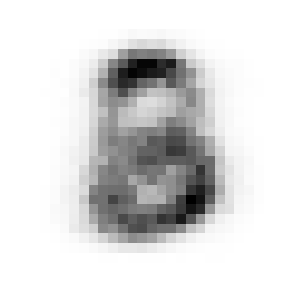

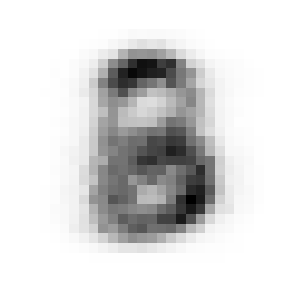

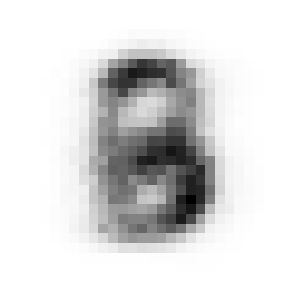

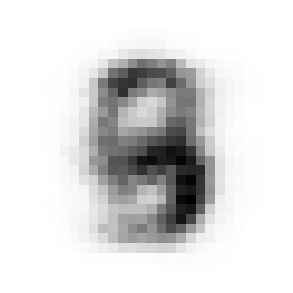

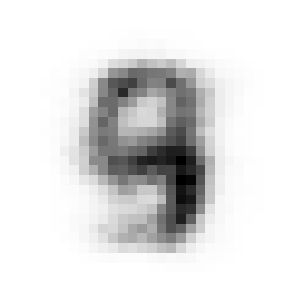

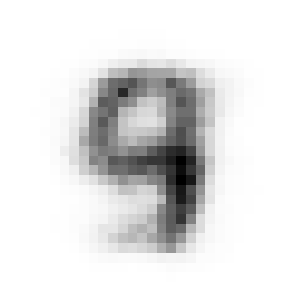

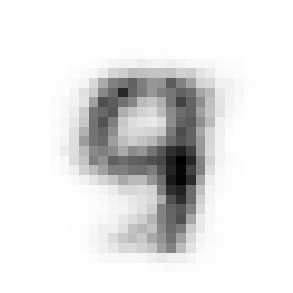

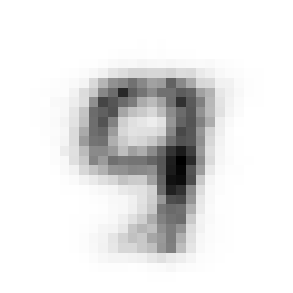

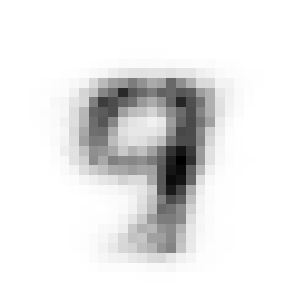

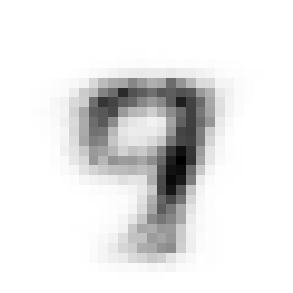

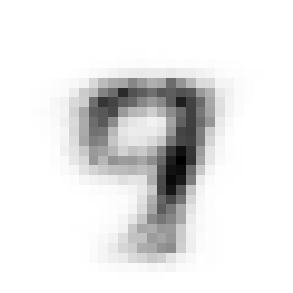

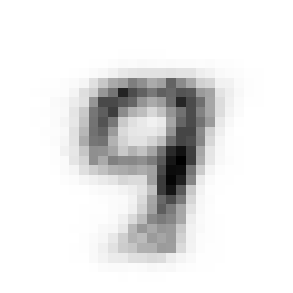

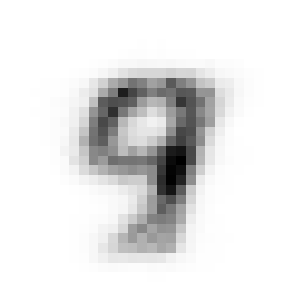

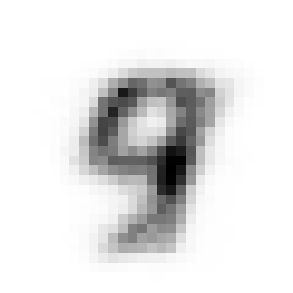

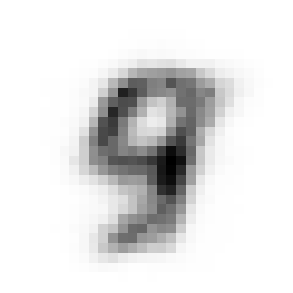

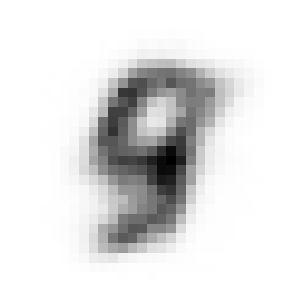

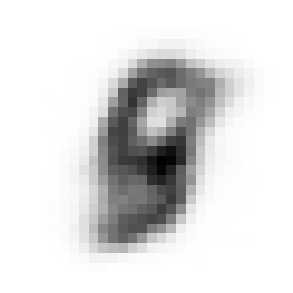

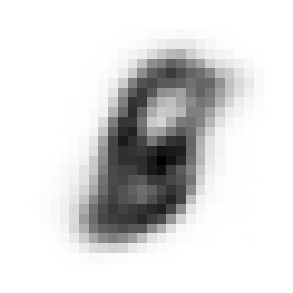

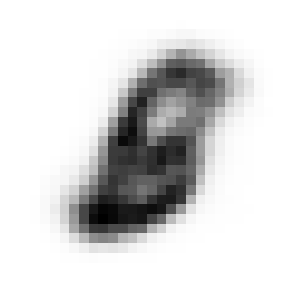

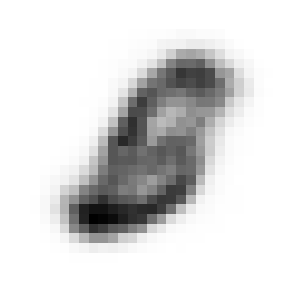

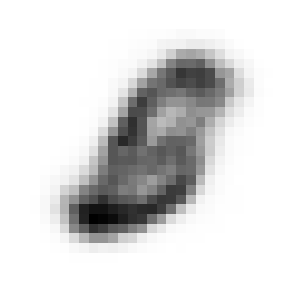

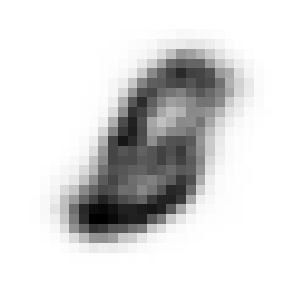

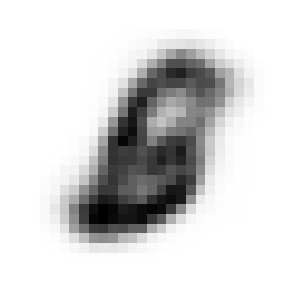

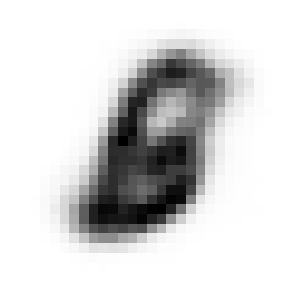

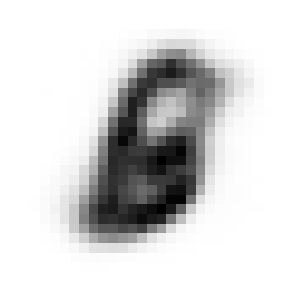

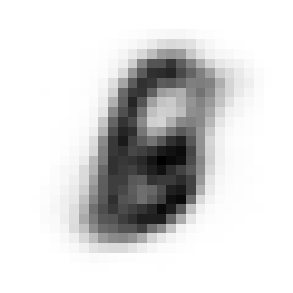

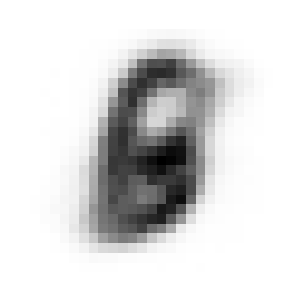

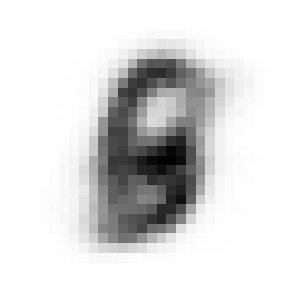

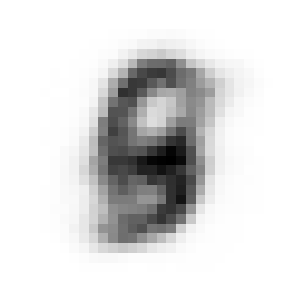

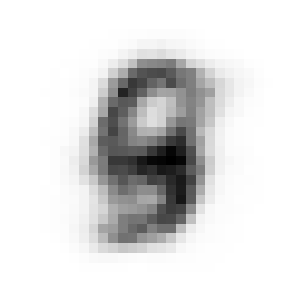

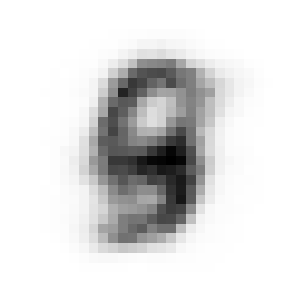

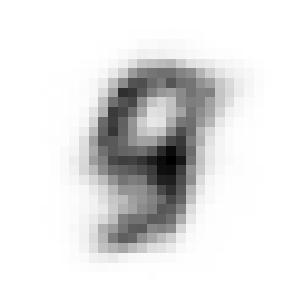

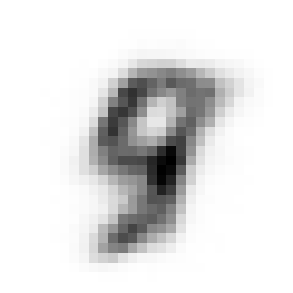

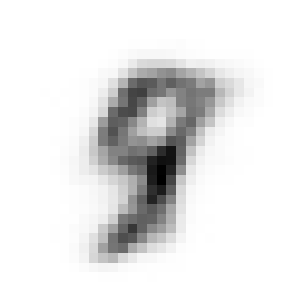

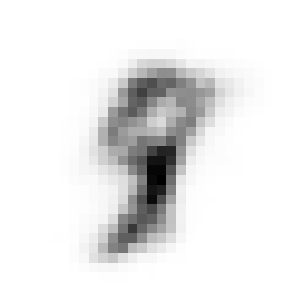

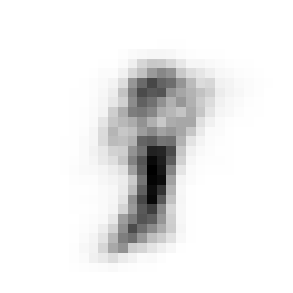

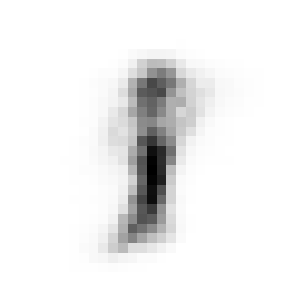

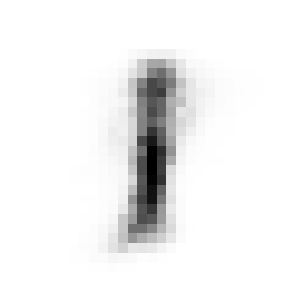

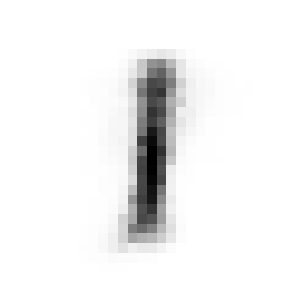

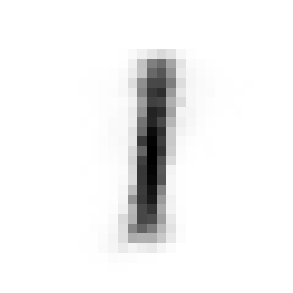

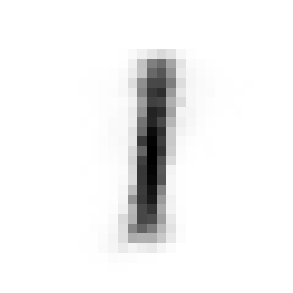

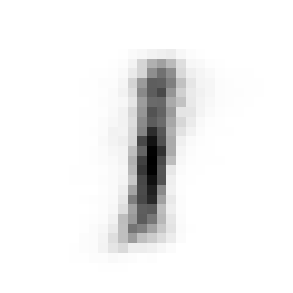

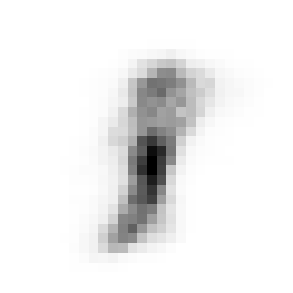

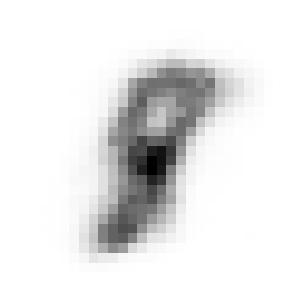

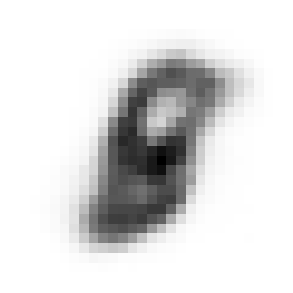

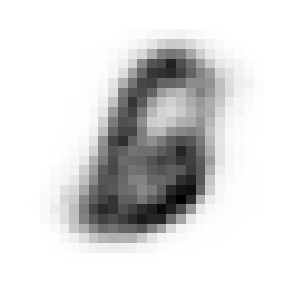

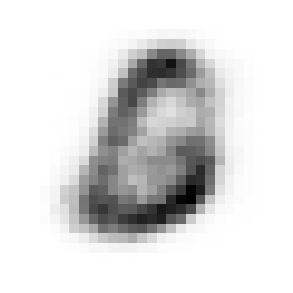

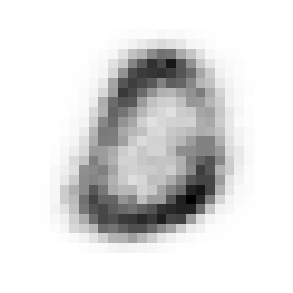

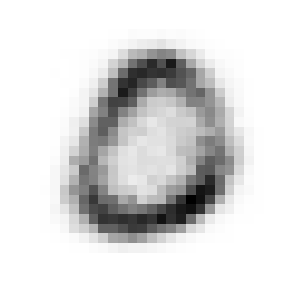

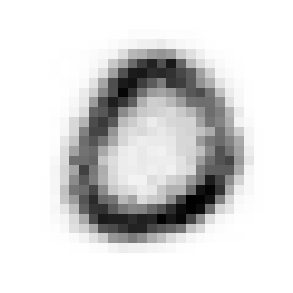

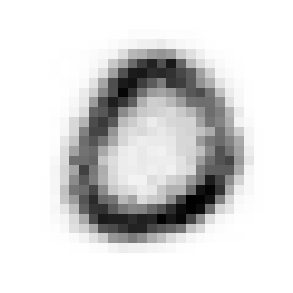

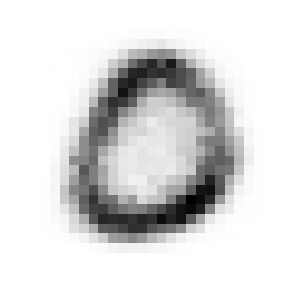

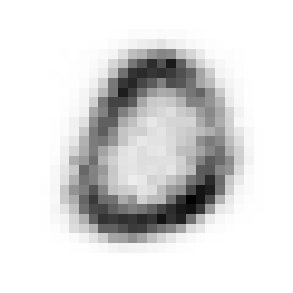

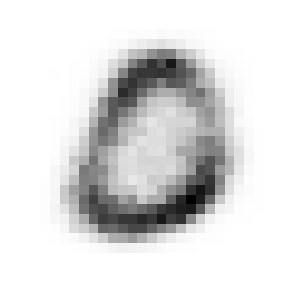

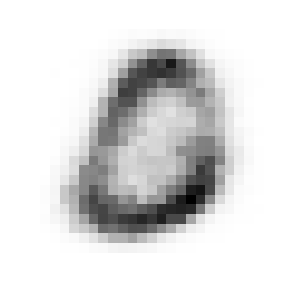

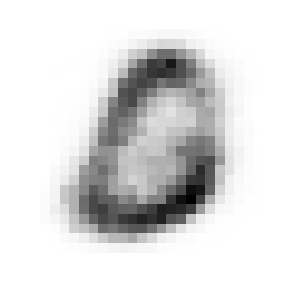

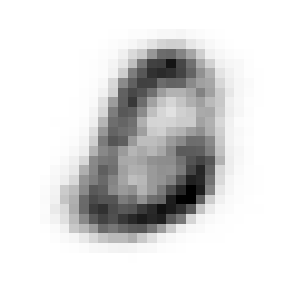

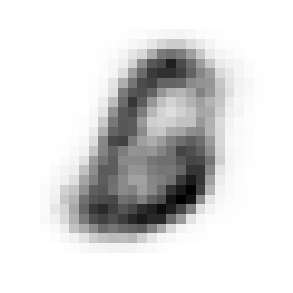

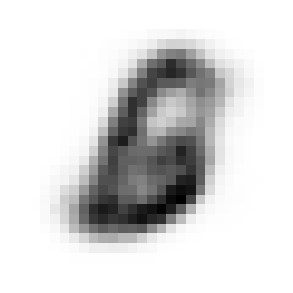

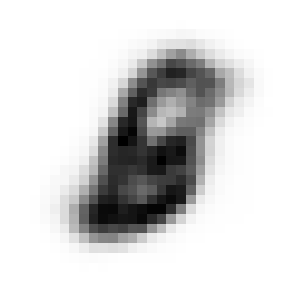

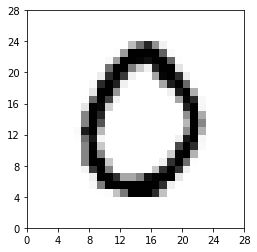

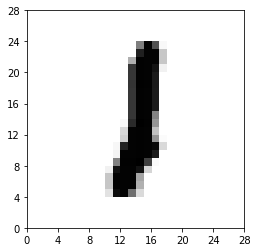

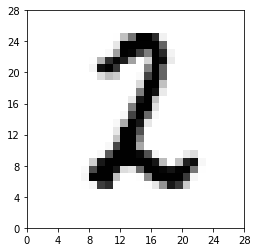

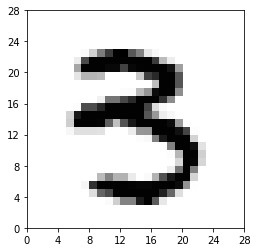

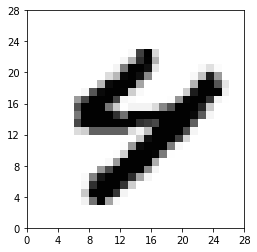

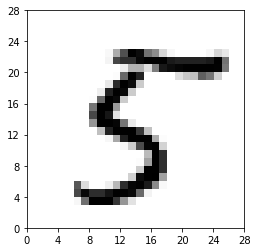

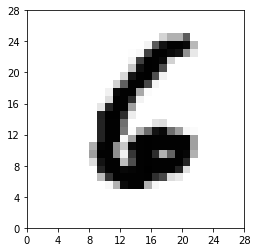

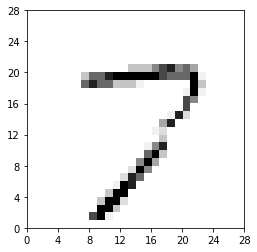

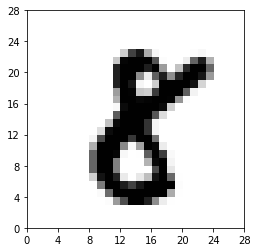

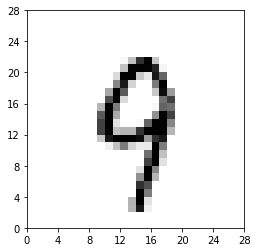

In [13]:
all_plots(v, mnist)

In [ ]:
def vae(model, x):
    # encode
    [mu, log_sigma] = model.encode(x)

In [23]:
# plot reconstructed/latent for a batch
xx,yy = mnist.train.next_batch(1000)

mu, sigma = v.encode(xx) 
xr = v.vae(xx)

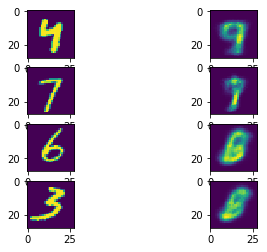

In [24]:
examples_plot = [0, 4, 6, 10]

for i, j in enumerate(examples_plot):
    plt.subplot(len(examples_plot), 2, (i+1)*2-1)
    plt.imshow(xx[j].reshape(28, 28))
    plt.subplot(len(examples_plot), 2, (i+1)*2)
    plt.imshow(xr[j].reshape(28, 28))

In [25]:
mu.shape

(1000, 2)

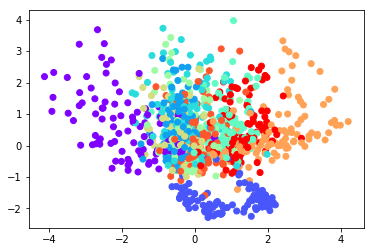

In [26]:
kwargs={}
classes = set(yy)
colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
kwargs['c'] = [colormap[i] for i in yy]
plt.scatter(mu[:,1], mu[:,0], **kwargs)